In [146]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

file_path = 'data/b_only_subset.csv'
out_B = 'data/csv/ucla_B.csv'
out_ret = 'data/csv/ucla_ret.csv'
out_smz = 'data/csv/ucla_smz.csv'
out_int = 'data/csv/ucla_int.csv'
out_cle = 'data/csv/ucla_cle.csv'
out_trl = 'data/csv/ucla_trl.csv'

df = pd.read_csv(out_ret, delimiter=',')

In [147]:
df['figures'] = df['figures'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df['figures'] = df['figures'].apply(lambda x: [y[:-1] if isinstance(y, str) and len(y) > 0 else y for y in x]) # Get rig of additional commas 
df['description'] = df['description'].apply(lambda x: x.split(';') if isinstance(x, str) else [])
df['genre'] = df['genre'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

data_filtered = df[df['figures'].apply(lambda x: len(x) > 0)]
most_common_figure = data_filtered.groupby('year')['figures'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_figure)

data_filtered = df[df['description'].apply(lambda x: len(x) > 0)]
most_common_description = data_filtered.groupby('year')['description'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_description)

data_filtered = df[df['genre'].apply(lambda x: len(x) > 0)]
most_common_genre = data_filtered.groupby('year')['genre'].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None)
#print(most_common_genre)

In [148]:
import re
from collections import Counter

def flatten_list(strings):
    flattened_list = []
    for item in strings:
        if isinstance(item, str):  # If item is a string, add it directly to the flattened list
            flattened_list.append(item)
        else:  # If item is a list, recursively flatten it
            flattened_list.extend(flatten_list(item))
    return flattened_list

all_genre = flatten_list(df.genre)
counted_genre = Counter(all_genre)

all_description = flatten_list(df.description)
counted_description = Counter(all_description)

all_figures = flatten_list(df.figures)
counted_figures = Counter(all_figures)

#print(counted_genre)
#print(counted_description)
#print(counted_figures)

In [149]:
ten_most_common_genre = [item[0] for item in counted_genre.most_common(10)]

# Count records per genre
genre_counts = {}

# Count total articles per year
total_counts = {}

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    year = row['year']
    genre_list = row['genre']

    # Increment the total count for the current year
    total_counts[year] = total_counts.get(year, 0) + 1
    
    # Iterate over each genre in the genres list for the current row
    for genre in genre_list:
        # Increment the count for the current genre and year
        genre_year = (genre, year)
        genre_counts[genre_year] = genre_counts.get(genre_year, 0) + 1

# Extract unique genres and years
genres = list(set([topic for topic, _ in genre_counts.keys()]))
years = list(set([year for _, year in genre_counts.keys()]))

# Sort the genres and years in ascending order
genres.sort()
years.sort()



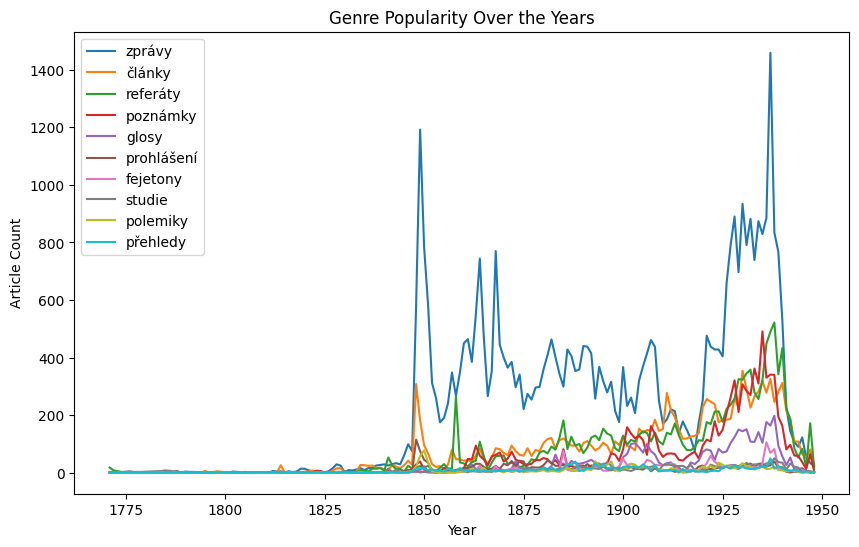

In [150]:
# Create a line chart
plt1 = plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the lines for each topic
for figure in ten_most_common_genre:
    counts = [genre_counts.get((figure, year), 0) for year in years]
    plt1 = plt.plot(years, counts, label=figure)

# Add labels and title
plt1 = plt.xlabel('Year')
plt1 = plt.ylabel('Article Count')
plt1 = plt.title('Genre Popularity Over the Years')

# Add a legend
plt1 = plt.legend()  

# Display the chart
plt.show()


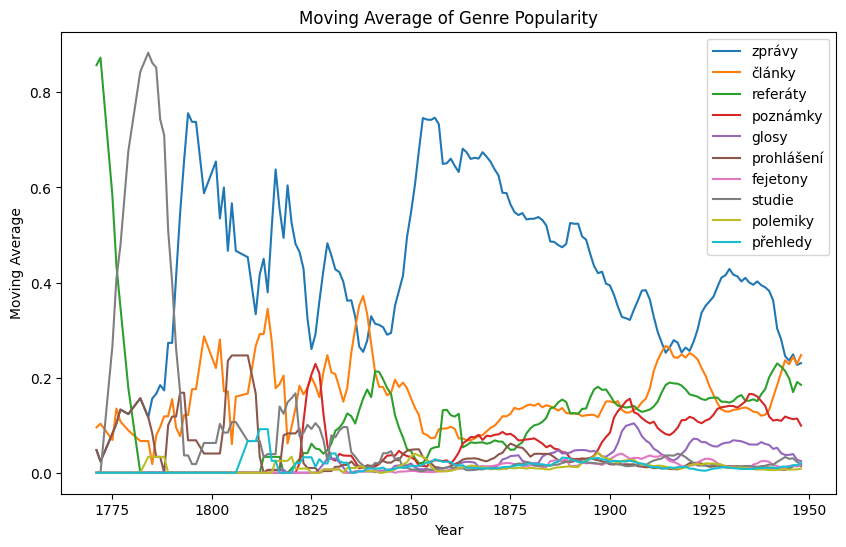

In [151]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

proportions = {}
# Plot the lines for each topic
for genre in ten_most_common_genre:
    proportions[genre] = [genre_counts.get((genre, year), 0) / total_counts[year] for year in years]

# Calculate moving average
window_size = 5  # Define the window size for the moving average
moving_averages = {}
for topic, values in proportions.items():
    moving_averages[topic] = pd.Series(values).rolling(window=window_size, min_periods=1).mean()


for genre in ten_most_common_genre:    
    plt.plot(years, moving_averages[genre], label=genre)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Moving Average')
plt.title('Moving Average of Genre Popularity')

# Add a legend
plt.legend()  

# Display the chart
plt.show()


In [152]:
ten_most_common_figures = [item[0] for item in counted_figures.most_common(10)]

# Count records per figure
figure_counts = {}

total_counts = {}
# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    year = row['year']
    figure_list = row['figures']
    

    total_counts[year] = total_counts.get(year, 0) + 1
    # Iterate over each genre in the genres list for the current row
    for figure in figure_list:
        # Increment the count for the current genre and year
        figure_year = (figure, year)
        figure_counts[figure_year] = figure_counts.get(figure_year, 0) + 1

# Extract unique genres and years
figures = list(set([topic for topic, _ in figure_counts.keys()]))
years = list(set([year for _, year in figure_counts.keys()]))

# Sort the genres and years in ascending order
figures.sort()
years.sort()

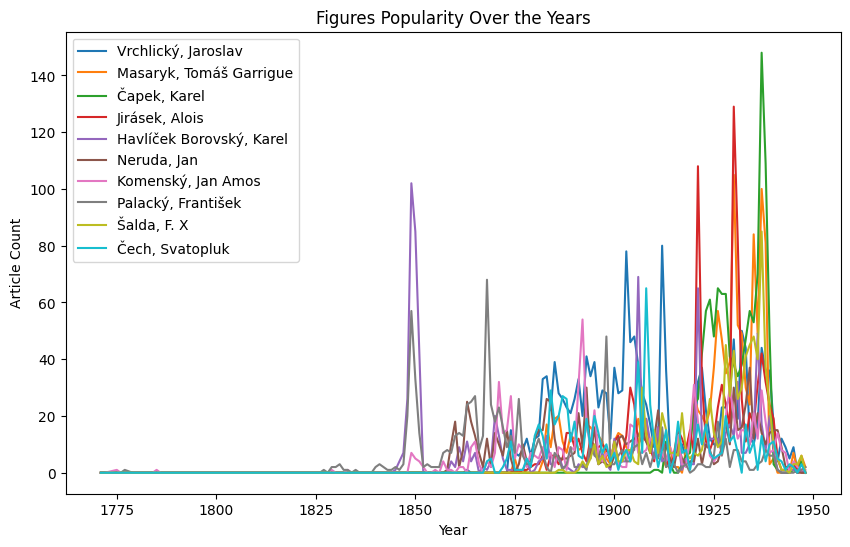

In [153]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the lines for each topic
for figure in ten_most_common_figures:
    counts = [figure_counts.get((figure, year), 0) for year in years]
    plt.plot(years, counts, label=figure)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.title('Figures Popularity Over the Years')

# Add a legend
plt.legend()  

# Display the chart
plt.show()


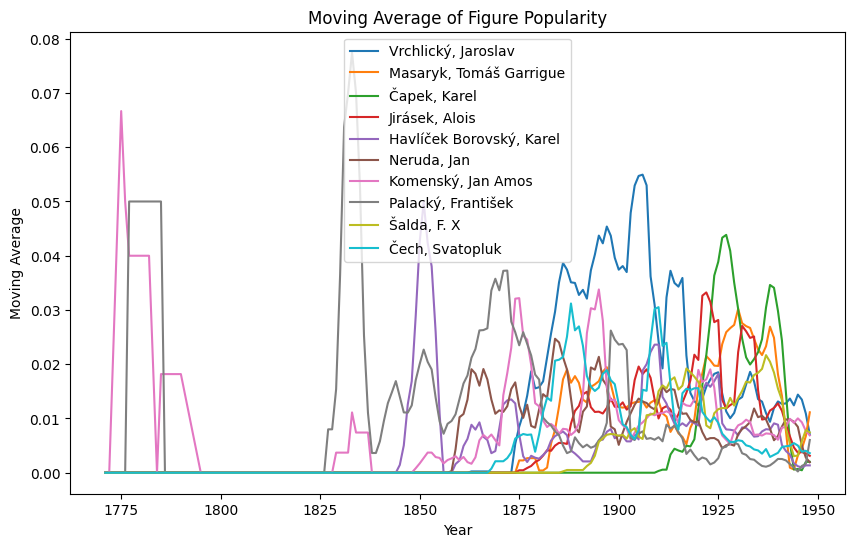

In [154]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

proportions = {}
# Plot the lines for each topic
for figure in ten_most_common_figures:
    proportions[figure] = [figure_counts.get((figure, year), 0) / total_counts[year] for year in years]

# Calculate moving average
window_size = 5  # Define the window size for the moving average
moving_averages = {}
for topic, values in proportions.items():
    moving_averages[topic] = pd.Series(values).rolling(window=window_size, min_periods=1).mean()


for figure in ten_most_common_figures:    
    plt.plot(years, moving_averages[figure], label=figure)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Moving Average')
plt.title('Moving Average of Figure Popularity')

# Add a legend
plt.legend()  

# Display the chart
plt.show()


In [155]:
ten_most_common_descriptions = [item[0] for item in counted_description.most_common(10)]

# Count records per figure
description_counts = {}

total_counts = {}
# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    year = row['year']
    description_list = row['description']
    
    total_counts[year] = total_counts.get(year, 0) + 1
    # Iterate over each genre in the genres list for the current row
    for description in description_list:
        # Increment the count for the current genre and year
        description_year = (description, year)
        description_counts[description_year] = description_counts.get(description_year, 0) + 1

# Extract unique genres and years
descriptions = list(set([topic for topic, _ in description_counts.keys()]))
years = list(set([year for _, year in description_counts.keys()]))

# Sort the genres and years in ascending order
descriptions.sort()
years.sort()

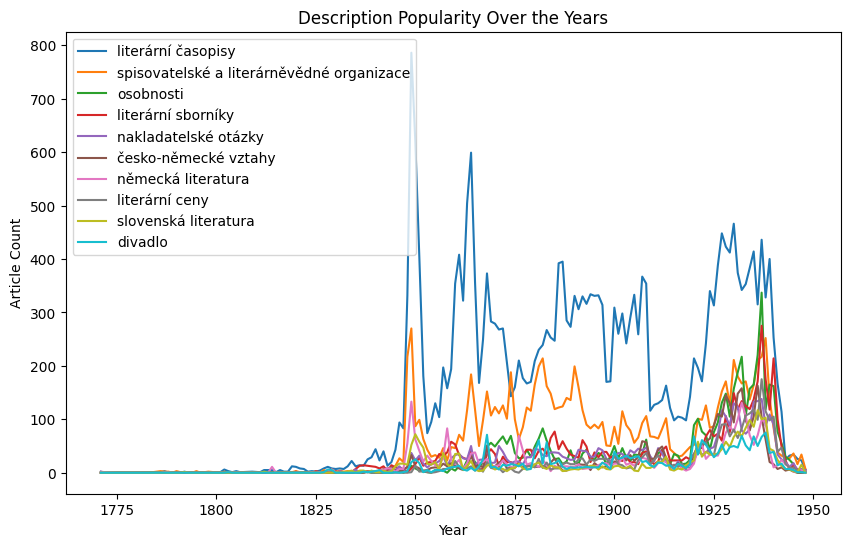

In [156]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the lines for each topic
for description in ten_most_common_descriptions:
    counts = [description_counts.get((description, year), 0) for year in years]
    plt.plot(years, counts, label=description)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Article Count')
plt.title('Description Popularity Over the Years')

# Add a legend
plt.legend()  

# Display the chart
plt.show()

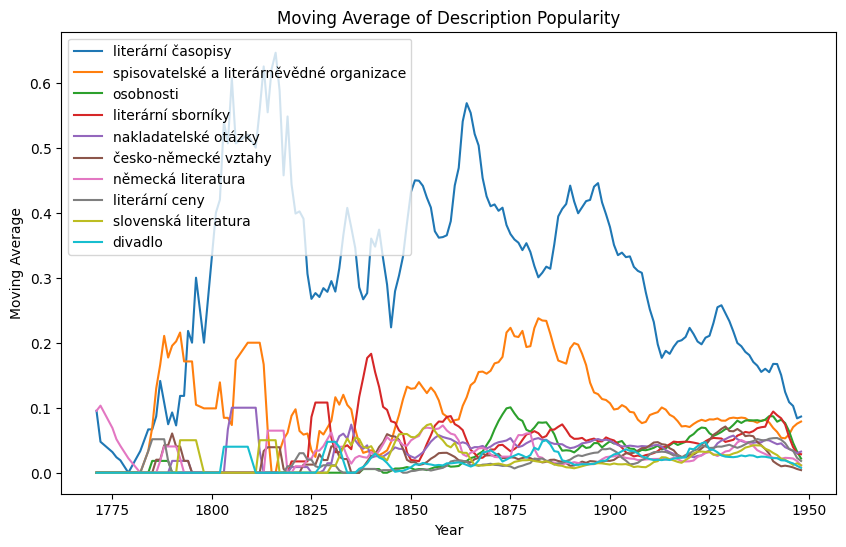

In [157]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

proportions = {}
# Plot the lines for each topic
for description in ten_most_common_descriptions:
    proportions[description] = [description_counts.get((description, year), 0) / total_counts[year] for year in years]

# Calculate moving average
window_size = 5  # Define the window size for the moving average
moving_averages = {}
for topic, values in proportions.items():
    moving_averages[topic] = pd.Series(values).rolling(window=window_size, min_periods=1).mean()


for description in ten_most_common_descriptions:    
    plt.plot(years, moving_averages[description], label=description)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Moving Average')
plt.title('Moving Average of Description Popularity')

# Add a legend
plt.legend()  

# Display the chart
plt.show()